<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Замена-символов" data-toc-modified-id="Замена-символов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Замена символов</a></span></li><li><span><a href="#Сокращения-в-полные-слова" data-toc-modified-id="Сокращения-в-полные-слова-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Сокращения в полные слова</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Подготовка выборок</a></span></li><li><span><a href="#Vectorization" data-toc-modified-id="Vectorization-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Vectorization</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Модели" data-toc-modified-id="Модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Модели</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Определение токсичности комментариев 

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров. Клиенты предлагают свои правки и комментируют изменения других. 
Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. 
В нашем распоряжении набор данных с разметкой о токсичности правок.

Нужна модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

* text — текст комментария;
* toxic — целевой признак.

## Подготовка данных

!pip install -U transformers
!pip install -U spacy
import sys  
!{sys.executable} -m pip install contractions

!pip install torch
!pip install transformers
!pip install BERT

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# NLP pre-processing
import contractions
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

# models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import transformers
import torch

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

#from tqdm import notebook 

#import warnings
#warnings.filterwarnings("ignore") 

In [2]:
STATE = 30

In [3]:
def first_glance(*args):
    '''
    Downloads the data; 
    prints: 
            info, 
            5 random rows, 
            the number of duplicates, 
            missing values info.
    
    Parameters
    ----------
    *args: str
        A list of possible csv file directories (only one of them will be used)
    
    Returns 
    ----------
    DataFrame
    
    '''
    for dir_name in args:
        try:
            data = pd.read_csv(dir_name)
        except:
            pass
    
    display('----------------Summary-----------------')
    data.info()
    
    display('------------5 random rows---------------', 
            data.sample(5, random_state=STATE))
    
    display('-------The number of duplicates---------', 
            data.duplicated().sum())
    
    if data.isna().sum().sum() != 0:
        # create dataframe with the number of nans by columns
        na_values = data.isna().sum().to_frame().rename(columns = {0: 'missing_values'})
        # add new column with nans percentage by columns
        na_values['% of total'] = (na_values['missing_values'] / data.shape[0]).round(2)
        # sort dataframe by the number of nans
        display('--The number and percentage of NA values--',
                na_values.sort_values(by = 'missing_values', ascending = False))
        
    return data

In [4]:
data = first_glance('/datasets/toxic_comments.csv', 'toxic_comments.csv')
display()

'----------------Summary-----------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


'------------5 random rows---------------'

,text,toxic
135769,"""\nThe Syrian army is now advancing on Aleppo ...",0
61266,"Oppose there is zero benefit to readers, parti...",0
10599,File:Skin of Our Teeth Handbill.jpg.\nYou have...,0
59039,Read before you speak.,0
117929,meatpuppets \nHi I know you dont like me editi...,0


'-------The number of duplicates---------'

0

0    143346
1     16225
Name: toxic, dtype: int64


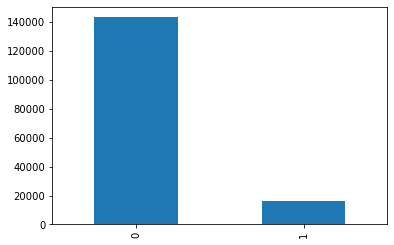

In [5]:
class_frequency = data['toxic'].value_counts(normalize=False) 
print(class_frequency)
class_frequency.plot(kind='bar')
plt.show()

In [6]:
df = data.copy()

### Замена символов

In [7]:
def replace_text(df, column, new_column):
    df[new_column] = df[column].str.replace(r"http\S+", "", regex=True)
    df[new_column] = df[new_column].str.replace(r"http", "")
    df[new_column] = df[new_column].str.replace(r"@\S+", "", regex=True)
    df[new_column] = df[new_column].str.replace(r"[^A-Za-z,\'\"]", " ", regex=True)
    df[new_column] = df[new_column].str.lower()
    
    return df

replace_text(df, "text", "clean")
df.head()

,text,toxic,clean
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he matches this background colour i'm s...
2,"Hey man, I'm really not trying to edit war. It...",0,"hey man, i'm really not trying to edit war it..."
3,"""\nMore\nI can't make any real suggestions on ...",0,""" more i can't make any real suggestions on im..."
4,"You, sir, are my hero. Any chance you remember...",0,"you, sir, are my hero any chance you remember..."


### Сокращения в полные слова

In [8]:
expanded = []
for row in df['clean']:
    expanded_row = []

    for word in row.split():
        expanded_row.append(contractions.fix(word))
        
    expanded.append(' '.join(expanded_row))

In [9]:
df['clean'] = pd.Series(expanded, index=df.index)
df.head()

,text,toxic,clean
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he matches this background colour I am s...
2,"Hey man, I'm really not trying to edit war. It...",0,"hey man, I am really not trying to edit war it..."
3,"""\nMore\nI can't make any real suggestions on ...",0,""" more i cannot make any real suggestions on i..."
4,"You, sir, are my hero. Any chance you remember...",0,"you, sir, are my hero any chance you remember ..."


### Лемматизация

In [10]:
nlp = spacy.load('en_core_web_sm')

In [11]:
def pipe_lemmas(rows):
    clean_rows = []
    for row in nlp.pipe(rows, batch_size=32, n_process=4):
        # removing stop words and getting lemmas
        clean_rows.append([token.lemma_ for token in row if not token.is_stop and not token.is_punct])
    
    return clean_rows

In [12]:
df['clean'] = pipe_lemmas(df['clean'])
df.head()

,text,toxic,clean
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edit, username, hardcore, metall..."
1,D'aww! He matches this background colour I'm s...,0,"[d'aww, match, background, colour, seemingly, ..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, try, edit, war, guy, constantly, re..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[real, suggestion, improvement, wonder, sectio..."
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page]"


### Подготовка выборок

In [13]:
all_words = [word for row in df['clean'] for word in row]
sentence_lengths = [len(row) for row in df['clean']]
vocabulary = sorted(list(set(all_words)))
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocabulary)}")
print(f"Max sentence length is {max(sentence_lengths)}")

4816194 words total, with a vocabulary size of 147235
Max sentence length is 1250


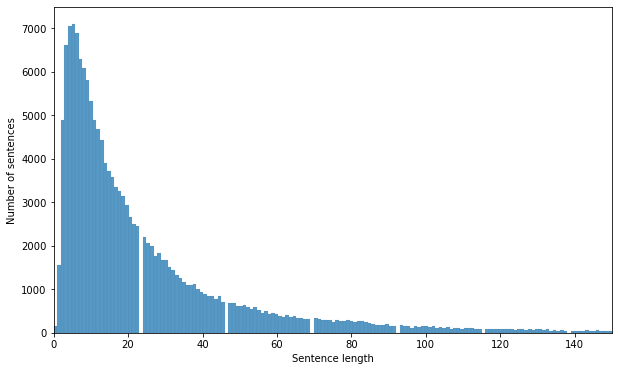

In [14]:
fig = plt.figure(figsize=(10, 6))
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
sns.histplot(sentence_lengths, kde=False)
plt.axis([0, 150, 0, 7500])
plt.show()

In [15]:
features = df['clean']
features = features.str.join(' ')

In [16]:
features_train, features_test, target_train, target_test = train_test_split(
                                features, df['toxic'],
                                test_size=.3, random_state=STATE)

print(features_train.shape)
print(features_test.shape)

(111699,)
(47872,)


In [17]:
target_train.shape

(111699,)

### Vectorization

In [18]:
tfidf_vec = TfidfVectorizer(ngram_range=(1, 3))
tfidf_vec.fit(features)

TfidfVectorizer(ngram_range=(1, 3))

In [19]:
features_train_tfidf = tfidf_vec.transform(features_train)
features_test_tfidf = tfidf_vec.transform(features_test)

print(features_train_tfidf.shape)
print(features_test_tfidf.shape)

(111699, 5922621)
(47872, 5922621)


### Вывод

Имеется файл с данными, которых содержит 159571 объектов и два столбца: исходный текст комментария и целевой признак. Пропуски отсутствуют. 

Целевой признак несбалансирован - одно из значений почти в 9 раз меньше другого.

Проведена предобработка данных:

* удалены лишние символы и буквосочетания;
* развернуты сокращения;
* проведена лемматизация с удалением стоп-слов;
* исследована длина комментариев и общее количество слов (159571 и 8750 соответственно);
* выделен целевой признак;
* данные разделены на обучающую и тестовую выборки;
* данные преобразованы в векторы с использованием TF-IDF метода, который позволяет учесть частоту слов в корпусе и тексте.

## Модели

### Logistic Regression

In [20]:
pipe = Pipeline([("vectorizer", TfidfVectorizer()),
                 ('classifier' , LogisticRegression(class_weight='balanced', 
                                                    n_jobs=-1, 
                                                    random_state=STATE))])

param_grid = [
              {'classifier' : [LogisticRegression()],
               'classifier__penalty' : ['l1', 'l2'],
               'classifier__C' : np.logspace(-4, 4, 20),
               'classifier__solver' : ['liblinear']}
             ]

clf = GridSearchCV(pipe, param_grid=param_grid, 
                   cv = 5, scoring='f1',
                   verbose=True, n_jobs=-1)

best_log_reg = clf.fit(features_train, target_train)
print('best parameters', best_log_reg.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
best parameters {'classifier': LogisticRegression(C=4.281332398719396, penalty='l1', solver='liblinear'), 'classifier__C': 4.281332398719396, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


In [21]:
predicted_test_log = best_log_reg.predict(features_test)
f1_test_log = f1_score(target_test, predicted_test_log)
print('f1_test', f1_test_log)

predicted_train_log = best_log_reg.predict(features_train)
f1_train_log = f1_score(target_train, predicted_train_log)
print('f1_train', f1_train_log)

print('best parameters', best_log_reg.best_params_)

f1_test 0.7943833678023294
f1_train 0.8949668687438319
best parameters {'classifier': LogisticRegression(C=4.281332398719396, penalty='l1', solver='liblinear'), 'classifier__C': 4.281332398719396, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    
    cm_df = pd.DataFrame(cm, columns=classes, index = classes)
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    plt.figure(figsize = (9, 6))
    sns.set(font_scale=1.4) # label size
    ax =sns.heatmap(cm_df, cmap=cmap, annot=True, 
                    annot_kws={"size": 16},fmt="d") # font size
    plt.title(title)
    bottom, top = ax.get_ylim()
    plt.show()

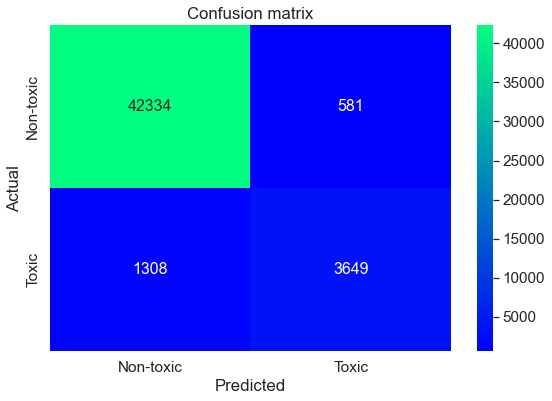

In [23]:
cm = confusion_matrix(target_test, predicted_test_log)
plot_confusion_matrix(cm, classes=['Non-toxic','Toxic'], normalize=False, 
                      title='Confusion matrix')

### Random Forest

In [24]:
forest_pipe=Pipeline(
                [("vectorizer", TfidfVectorizer(ngram_range=(1, 3))),
                ("classifier", RandomForestClassifier(random_state=STATE, 
                             class_weight='balanced'))]
                    )

parameters = [
             {'classifier' : [RandomForestClassifier()],
              'classifier__n_estimators': range (50, 150, 20),
              'classifier__max_depth': range (1, 13, 2)}
             ]

clf = GridSearchCV(forest_pipe, param_grid=parameters, 
                           scoring='f1', 
                           cv=5, n_jobs=-1)

best_forest = clf.fit(features_train, target_train)
print('best parameters', clf.best_params_)

best parameters {'classifier': RandomForestClassifier(max_depth=1, n_estimators=50), 'classifier__max_depth': 1, 'classifier__n_estimators': 50}


In [25]:
forest_clf = RandomForestClassifier(n_estimators=50, 
                                   max_depth=1,
                                   n_jobs=-1,
                                   class_weight='balanced',
                                   random_state=STATE)

forest_clf.fit(features_train_tfidf, target_train)

predicted_test_forest = forest_clf.predict(features_test_tfidf)
f1_test_forest = f1_score(target_test, predicted_test_forest)
print('f1_test', f1_test_forest)

predicted_train_forest = forest_clf.predict(features_train_tfidf)
f1_train_forest = f1_score(target_train, predicted_train_forest)
print('f1_train', f1_train_forest)

f1_test 0.2071984863818366
f1_train 0.20062275901113416


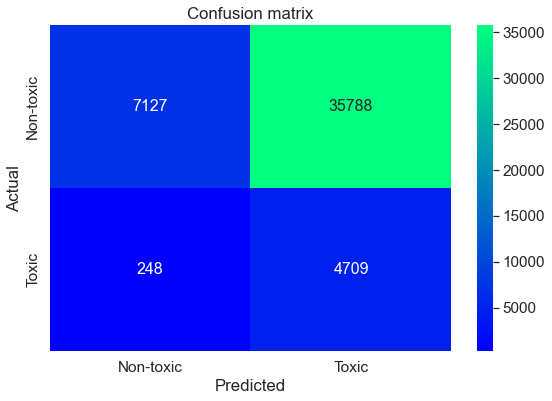

In [26]:
cm2 = confusion_matrix(target_test, predicted_test_forest)
plot_confusion_matrix(cm2, classes=['Non-toxic','Toxic'], normalize=False, 
                      title='Confusion matrix')

### Вывод

Обучены и протестированы две модели - логистическая регрессия и случайный лес с использованием гиперпараметра баланса целевого класса.
Построены матрицы ошибок для каждой модели.

## Общий вывод

In [27]:
pd.DataFrame(data=[[f1_train_log,
                   f1_test_log],
                   [f1_train_forest,
                   f1_test_forest]],
            columns=['F1 train', 'F1 test'],
            index=['Logistic_Regression',
                  'Random_Forest'])

,F1 train,F1 test
Logistic_Regression,0.894967,0.794383
Random_Forest,0.200623,0.207198


Построены модели предсказаний целевых признаков. В качестве основной метрики была использована метрика f1 (среднее гармоническое полноты и точности).

По итогам тестирования выбрана модель логистической регрессии, т.к. она дала лучший показатель метрики f1 - 0.79 на тестовой выборке.

Модель классифицирует комментарии на негативные ("toxic") и нейтральные, что позволит эффективно модерировать описания к товарам онлайн магазина и поможет покупателям быстрее определиться с покупкой в комфортной среде.